In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer

In [2]:
df_01 = pd.read_csv('data/stemmed_merged_kubu_01.csv')
df_02 = pd.read_csv('data/stemmed_merged_kubu_02.csv')
df_03 = pd.read_csv('data/stemmed_merged_kubu_03.csv')

In [3]:
indo_stopwords = [
    # Basic Indonesian stopwords (keep these)
    "yang", "dan", "di", "dengan", "untuk", "dari", "ke", "pada", "ini", "itu",
    "atau", "ada", "juga", "dalam", "saya", "kamu", "anda", "mereka", "kita", "kami",
    "dia", "nya", "adalah", "akan", "oleh", "seperti", "telah", "sudah", "bisa", "dapat",
    "tidak", "tak", "jangan", "ya", "via", "yg", "dgn", "utk", "dr", "pd", "dlm", "sdh", "tdk",
    
    # All candidate names and variations (since they appear everywhere)
    "anies", "baswedan", "rasyid", "muhaimin", "iskandar", "cak", "imin", "gus", 
    "prabowo", "subianto", "gibran", "rakabuming", "raka", "ganjar", "pranowo", 
    "mahfud", "md", "gama", "mawi", "abdurrahman", "abdul", "amin"
    
    # Titles and name prefixes
    "mas", "pak", "bu", "bapak", "ibu", "om", "tante", "mbak", "bro", "sis", "bang", 
    "abang", "kak", "adek", "adik", "kakak", "bung", "prof", "dr", "haji", "hajah", "h",
    
    # Social media expressions
    "rt", "dm", "pm", "cc", "wkwk", "haha", "woi", "hey", "ah", "eh", "oh", "hmm", "btw",
    "omg", "lol", "sih", "aja", "gitu", "banget", "kok", "deh", "ih", "yuk", "mantap",
    "insya", "insyaallah", "alhamdulillah", "bismillah", "amin", "allahuma", "allah",
    
    # Locations
    "jakarta", "jawa", "barat", "timur", "tengah", "utara", "selatan", "sumatra", "bali", 
    "aceh", "kota", "desa", "daerah", "wilayah", "provinsi", "kabupaten", "kawasan",
    "bandung", "surabaya", "makassar", "balikpapan", "semarang", "yogyakarta", "solo",
    
    

]

In [4]:

vectorizer = CountVectorizer(
    stop_words=indo_stopwords,
    ngram_range=(1, 3),  # Keep bigrams and trigrams for political phrases
    min_df=5,            # Lower threshold to capture more specific topics
    max_df=0.7           # Stricter upper bound to remove very common terms
)

# Configure UMAP for better clustering of political content
umap_model = UMAP(
    n_neighbors=15,      # Smaller neighborhood for more specific clusters
    n_components=5,      
    min_dist=0.0,        # Adjusted for better separation
    metric='cosine',
    random_state=42
)

# More sensitive clustering for political topics
hdbscan_model = HDBSCAN(
    min_cluster_size=10,  # Smaller clusters to capture specific campaign themes
    min_samples=5,       # More lenient sample requirement
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# Improved c-TF-IDF weighting
ctfidf_model = ClassTfidfTransformer(
    reduce_frequent_words=True,
    bm25_weighting=True
)

embedding_model = SentenceTransformer(
    'distiluse-base-multilingual-cased-v1'
)

# Configure BERTopic for Indonesian political content
topic_model = BERTopic(
    language="multilingual",  # Keep multilingual for Indonesian
    calculate_probabilities=True,
    verbose=True,
    nr_topics=15,             # Reduced from 15 to get more focused topics
    min_topic_size=5,         # Smaller topics to capture campaign themes
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    ctfidf_model=ctfidf_model,
    vectorizer_model=vectorizer,
    embedding_model=embedding_model,
)


# Fit the model
topics, probs = topic_model.fit_transform(df_01['full_text'].tolist())

2025-05-22 19:20:11,413 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/934 [00:00<?, ?it/s]

2025-05-22 19:20:16,568 - BERTopic - Embedding - Completed ✓
2025-05-22 19:20:16,569 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-22 19:20:41,717 - BERTopic - Dimensionality - Completed ✓
2025-05-22 19:20:41,718 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-22 19:24:36,406 - BERTopic - Cluster - Completed ✓
2025-05-22 19:24:36,407 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-22 19:24:37,005 - BERTopic - Representation - Completed ✓
2025-05-22 19:24:37,006 - BERTopic - Topic reduction - Reducing number of topics
2025-05-22 19:24:37,021 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-22 19:24:37,454 - BERTopic - Representation - Completed ✓
2025-05-22 19:24:37,456 - BERTopic - Topic reduction - Reduced number of topics from 371 to 15


In [5]:
# Generate more intuitive topic labels
topic_labels = {}
for topic_id in topic_model.get_topic_info()["Topic"]:
    if topic_id == -1:
        topic_labels[topic_id] = "outlier"
        continue
        
    # Get top words
    words = [word for word, _ in topic_model.get_topic(topic_id)[:5]]
    
    # Map topics to campaign themes based on keywords
    if any(term in words for term in ["palestina", "doa", "gelar", "bukittinggi"]):
        topic_labels[topic_id] = "Kampanye Palestina"
    elif any(term in words for term in ["aceh", "warga", "sambut", "bandara", "kedatagan"]):
        topic_labels[topic_id] = "Kunjungan ke Aceh"
    elif any(term in words for term in ["sumbar", "sumatra", "barat", "safari"]):
        topic_labels[topic_id] = "Kampanye Sumatra Barat"
    elif any(term in words for term in ["adil", "makmur", "sejahtera", "rakyat"]):
        topic_labels[topic_id] = "Visi Keadilan & Kemakmuran"
    elif any(term in words for term in ["menang", "indonesia", "senang", "bismillah"]):
        topic_labels[topic_id] = "Dukungan Kemenangan"
    elif any(term in words for term in ["pesantren", "santri", "tenanan", "kiai"]):
        topic_labels[topic_id] = "Dukungan Pesantren & Santri"
    elif any(term in words for term in ["partai", "bangkit", "bangsa"]):
        topic_labels[topic_id] = "Dukungan Partai Politik"
    else:
        # Use top 3 words as label for other topics
        topic_labels[topic_id] = " & ".join(words[:3])

# Apply custom labels
topic_model.set_topic_labels(topic_labels)

In [6]:

from wordcloud import WordCloud


Improved Topic Information:
   Topic  Count                                               Name  \
0     -1  10711                           -1_bicara_suka_isu_desak   
1      0  10304        0_presiden 01_01 01_calon presiden 01_teman   
2      1   4412   1_pilih presiden_makmur_adil makmur_menang pilih   
3      2   1360              2_politik_demokrasi_partai_legislatif   
4      3   1342                     3_debat_kritik_komentar_dialog   
5      4    569                     4_video_videotron_film_youtube   
6      5    334                  5_program_gratis_makan_program 01   
7      6    279                6_twitter_berita_media_media sosial   
8      7    214  7_01 pintar_orang pintar_pintar bicara_orang b...   
9      8    145                      8_palestina_merdeka_aksi_free   

                                 CustomName  \
0                                   outlier   
1   presiden 01 & 01 01 & calon presiden 01   
2                Visi Keadilan & Kemakmuran   
3           

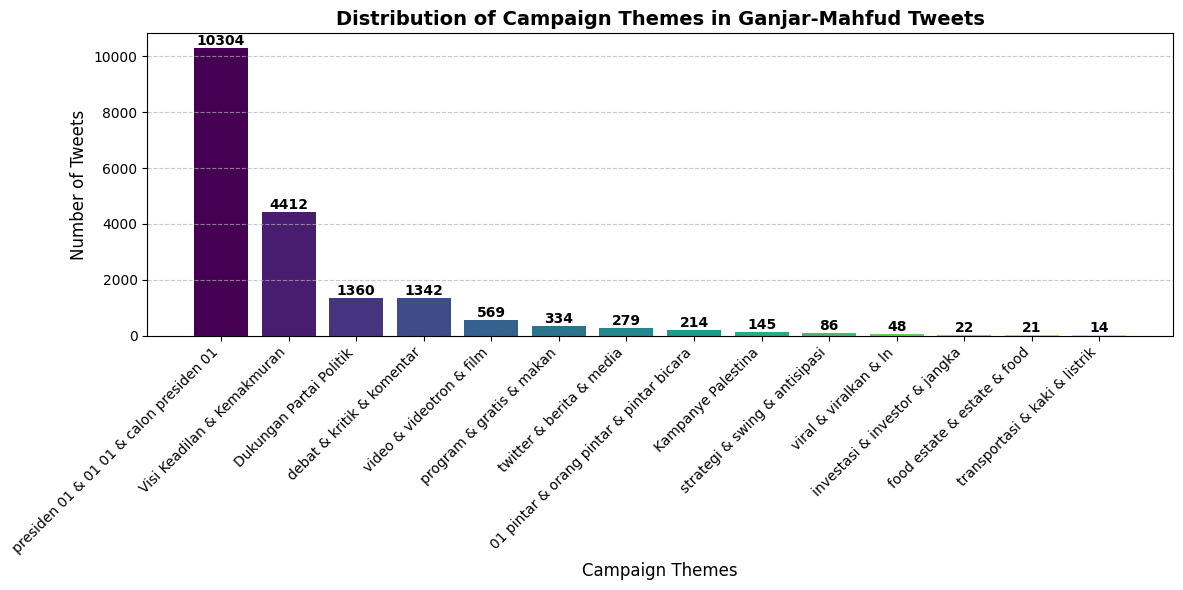

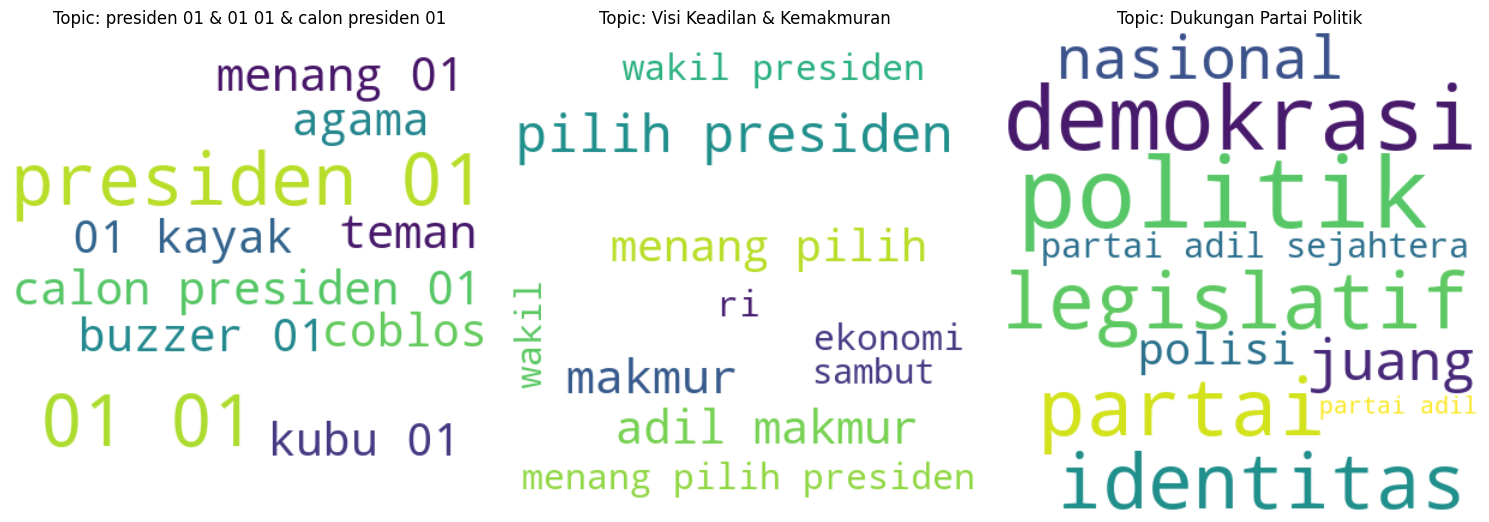

In [7]:
# Get the improved topic information
topic_info = topic_model.get_topic_info()
print("\nImproved Topic Information:")
print(topic_info.head(10))

# Print topics with their new labels
print("\nCampaign Themes for Ganjar-Mahfud:")
for index, row in topic_info.iterrows():
    if row["Topic"] != -1:  # Skip outlier topic
        topic_id = row["Topic"]
        words = [word[0] for word in topic_model.get_topic(topic_id)[:8]]
        print(f"Theme: {row['Name']}")
        print(f"Keywords: {', '.join(words)}")
        print(f"Document count: {row['Count']}")
        print("-" * 50)

# Create a topic distribution visualization
plt.figure(figsize=(12, 6))
topic_counts = topic_info[topic_info["Topic"] != -1]["Count"]
topic_names = [label for topic, label in topic_labels.items() if topic != -1][:len(topic_counts)]

# Plot with better color scheme
bars = plt.bar(topic_names, topic_counts, color=plt.cm.viridis(np.linspace(0, 1, len(topic_counts))))

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45, ha="right")
plt.title("Distribution of Campaign Themes in Ganjar-Mahfud Tweets", fontsize=14, fontweight='bold')
plt.xlabel("Campaign Themes", fontsize=12)
plt.ylabel("Number of Tweets", fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Display interactive visualizations
intertopic_map = topic_model.visualize_topics()
display(intertopic_map)

# Create hierarchical clustering visualization
hierarchy = topic_model.visualize_hierarchy()
display(hierarchy)

# Create heatmap of topic similarities
heatmap = topic_model.visualize_heatmap()
display(heatmap)

# Create word clouds for top 3 topics
plt.figure(figsize=(15, 10))
for i, topic_id in enumerate(topic_info[topic_info['Topic'] != -1]['Topic'][:3]):
    plt.subplot(1, 3, i+1)
    
    # Get topic words and weights
    words = dict(topic_model.get_topic(topic_id)[:15])
    
    # Create and display wordcloud
    wordcloud = WordCloud(width=400, height=400, background_color='white', 
                          colormap='viridis', max_words=50).generate_from_frequencies(words)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Topic: {topic_labels[topic_id]}", fontsize=12)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
from wordcloud import WordCloud
import seaborn as sns

In [9]:
# Create topic distribution from the existing topic_info
topic_distribution = topic_info.set_index("Topic")["Count"]

# Get representative documents for key campaign themes
print("\nRepresentative tweets for key campaign themes:")
key_topics = [t for t in topic_distribution.index if t != -1][:5]

for topic_id in key_topics:
    theme_name = topic_model.get_topic_info().loc[topic_model.get_topic_info()["Topic"] == topic_id, "Name"].values[0]
    print(f"\n--- Theme: {theme_name} ---")
    rep_docs = topic_model.get_representative_docs(topic_id)
    for i, doc in enumerate(rep_docs[:3]):
        print(f"{i+1}. {doc[:200]}...")


Representative tweets for key campaign themes:

--- Theme: 0_presiden 01_01 01_calon presiden 01_teman ---
1. model kubu 01 isu bohong nyinyir fitnah benci lain jago menang rendah lawan bikin prestasi...
2. apa kakak kalah bangga lo baris 01 calon presiden calon wakil presiden taat atur kampanye harga akal pikir kalah hormat menang belakang...
3. alah 01 partai adil sejahtera daerah pasar manis purwokerto kartu tanda duduk foto data mungut suara suruh pilih anis...

--- Theme: 1_pilih presiden_makmur_adil makmur_menang pilih ---
1. anies salah pilih pasang cak imin calon wakil presiden dada dipaksain surya paloh calon presiden calon wakil presiden 02 hebat wajib dipilir lurr...
2. calon wakil presiden calon wakil presiden koalisi ubah muhaimin iskandar akrab sapa cak imin sindir anak muda suka instan pimpin instan...
3. calon presiden calon presiden anies baswedan calon wakil presiden calon wakil presiden muhaimin iskandar cak imin amin terima kartu anggota muhammadiyah anggota hormat